In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget

# Simulating Nonreciprocal Cahn-Hilliard equations

## Nonreciprocal Cahn-Hilliard equations

The concentrations of species $S\in{A, B}$ are described by fields $\phi_S(\mathbf{r}, t)$, which evolve according to the dynamical equations
$$\dot{\phi}_S = \Delta \mu_S,$$
where $\mu_S$ denotes the effective nonrequilibrium chemical potential
$$\mu_S = \mu_S^{\rm eq} + \sum_{S'} \alpha_{SS'}\phi_{S'}.$$
For simplicity, we set $\alpha_{AA}=\alpha_{BB}=0$, $\alpha_{AB}=-\alpha_{BA}=\alpha$, such that the strength of nonreciprocity is controlled by $\alpha$.
The equilibrium chemical potential $\mu_S^{\rm eq}=\delta F / \delta \phi_S$ is the functional derivative of a free-energy functional $F[\{\phi_S\}]$, which can be written as
$$F=\int \mathrm{d}\mathbf{r}\left[\sum_{S\in\{A, B\}} (\phi_S-c_{S,1})^2(\phi_S-c_{S,2})^2+\chi\phi_A\phi_B+\chi'\phi_A^2\phi_B^2 + \frac{\kappa}{2}\sum_{S\in\{A,B\}} |\nabla \phi_S|^2\right].$$
Accordingly, the equilibirum chemical potentials read
$$
\mu_A^{\rm eq} = 2(\phi_A-c_{A,1})(\phi_A-c_{A,2})(2\phi_A-c_{A,1}-c_{A,2}) + \chi \phi_B + 2\chi'\phi_A\phi_B^2 - \kappa \Delta \phi_A, \\
\mu_B^{\rm eq} = 2(\phi_B-c_{B,1})(\phi_B-c_{B,2})(2\phi_B-c_{B,1}-c_{B,2}) + \chi \phi_A + 2\chi'\phi_A^2\phi_B -\kappa \Delta \phi_B.
$$
Denoting the bulk chemical potentials as $g_S(\phi_A, \phi_B)$, the concentration fields $\phi_S$ evolve as
$$\dot{\phi}_S = \Delta \left(g_S(\phi_A, \phi_B) - \kappa \Delta \phi_S\right)
$$


In [2]:
def get_g_A(phi_A, phi_B, cA_1, cA_2, chi, chi_prime, alpha):
    return 2 * (phi_A-cA_1) * (phi_A-cA_2) * (2*phi_A-cA_1-cA_2) + (chi+alpha) * phi_B + 2 * chi_prime * phi_A * phi_B ** 2

def get_g_B(phi_A, phi_B, cB_1, cB_2, chi, chi_prime, alpha):
    return 2 * (phi_B-cB_1) * (phi_B-cB_2) * (2*phi_B-cB_1-cB_2) + (chi-alpha) * phi_A + 2 * chi_prime * phi_B * phi_A ** 2


In Fourier space, we get
$$\frac{d}{dt}\tilde{\phi}_S(\mathbf{k}, t)= -k^2\left [\left\{\tilde{g}_S(\phi_A, \phi_B)\right\}_\mathbf{k} +\kappa k^2\tilde{\phi_S}\right],$$
where $\mathbf{k}=k_\alpha\mathbf{e}_\alpha$ is a vector in the Fourier space and $k = |\mathbf{k}|$.

## Initialization
For a 2d-case, suppose the simulation domain $[0, L_x]\times[0, L_y]$ is divided into $N_x \times N_y$ grids.

In [3]:
dt = 5e-4
spacing = 0.02
Nx = Ny = 128 # Nx and Ny should be even
Lx = Ly = Nx * spacing

## Average concentration
phiA_0 = 0.35
# phiB_0 = 0.3
phiB_0 = 0.42

## Nonreciprocity
alpha = 0.4

np.random.seed(1234)
phiA = np.ones((Ny, Nx)) * phiA_0 + (np.random.rand(Ny, Nx) - 0.5) * 0.001
phiB = np.ones((Ny, Nx)) * phiB_0 + (np.random.rand(Ny, Nx) - 0.5) * 0.001

cA_1 = 0.2
cA_2 = 0.5
cB_1 = 0.1
cB_2 = 0.5
chi = -0.2
chi_prime = 0
kappa = 1e-4

phiA_k = np.fft.rfft2(phiA)
phiB_k = np.fft.rfft2(phiB)

ky = np.zeros(Ny)
kx = np.zeros(Nx // 2 + 1)
for i in range(Ny):
    if i < Ny // 2:
        ky[i] = i / (Ny * spacing) * np.pi * 2
    else:
        ky[i] = (i - Ny) / (Ny * spacing) * np.pi * 2
for i in range(Nx // 2 + 1):
    kx[i] = i / (Nx * spacing) * np.pi * 2
kxx, kyy = np.meshgrid(kx, ky)
k2 = kxx ** 2 + kyy ** 2


def show_fields(phiA, phiB, t):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True, constrained_layout=True)
    im1 = ax1.imshow(phiA, origin="lower")
    im2 = ax2.imshow(phiB, origin="lower")
    plt.colorbar(im1, ax=ax1)
    plt.colorbar(im2, ax=ax2)
    fig.suptitle(r"$t=%g$" % t)
    plt.show()
    plt.close()
    

## Time integration
### Explicit Euler Fourier-spectral method
Approximate the above equations by the explicit Euler scheme
$$\tilde{\phi}^{n+1}_S= \tilde{\phi}^n_S - \Delta t k^2 \left[\left \{\tilde{g}_S^n\right \}_\mathbf{k}+\kappa{k^2}\tilde{\phi}_S^n\right]$$

In [4]:
coeff1 = 1 - dt  * k2 * k2 * kappa
coeff2 = -dt * k2

def exEulerFS(phiA, phiB, phiA_k, phiB_k):
    g_A = get_g_A(phiA, phiB, cA_1, cA_2, chi, chi_prime, alpha)
    g_B = get_g_B(phiA, phiB, cB_1, cB_2, chi, chi_prime, alpha)
    g_A_k = np.fft.rfft2(g_A)
    g_B_k = np.fft.rfft2(g_B)
    phiA_k_next = coeff1 * phiA_k + coeff2 * g_A_k
    phiB_k_next = coeff1 * phiB_k + coeff2 * g_B_k
    phiA_next = np.fft.irfft2(phiA_k_next)
    phiB_next = np.fft.irfft2(phiB_k_next)
    return phiA_next, phiB_next, phiA_k_next, phiB_k_next


def run_exEulerFS(phiA, phiB, phiA_k, phiB_k, n_step, dn_out):
    for i in range(n_step):
        if i % dn_out == 0:
            show_fields(phiA, phiB, i * dt)
        phiA, phiB, phiA_k, phiB_k = exEulerFS(phiA, phiB, phiA_k, phiB_k)


### The first-order semi-implicit Fourier-spectral scheme
$$\left(1+\kappa\Delta tk^4\right)\tilde{\phi}_S^{n+1}= \tilde{\phi}_S^n - \Delta t k^2 \left \{\tilde{g}_S\right \}_\mathbf{k}$$

In [5]:
coeff3 = 1 / (1 + kappa * dt * k2 * k2)
coeff4 = -dt * k2
def simFS1(phiA, phiB, phiA_k, phiB_k):
    g_A = get_g_A(phiA, phiB, cA_1, cA_2, chi, chi_prime, alpha)
    g_B = get_g_B(phiA, phiB, cB_1, cB_2, chi, chi_prime, alpha)
    g_A_k = np.fft.rfft2(g_A)
    g_B_k = np.fft.rfft2(g_B)

    phiA_k_next = coeff3 * (phiA_k + coeff4 * g_A_k)
    phiB_k_next = coeff3 * (phiB_k + coeff4 * g_B_k)

    phiA_next = np.fft.irfft2(phiA_k_next)
    phiB_next = np.fft.irfft2(phiB_k_next)
    return phiA_next, phiB_next, phiA_k_next, phiB_k_next


def run_simFS1(phiA, phiB, phiA_k, phiB_k, n_step, dn_out):
    for i in range(n_step):
        if i % dn_out == 0:
            show_fields(phiA, phiB, i * dt)
        phiA, phiB, phiA_k, phiB_k = simFS1(phiA, phiB, phiA_k, phiB_k)

### The second-order BDF/AB scheme
$$\left(3 +  2\kappa\Delta t k^4\right)\tilde{\phi}_S^{n+1}(\mathbf{k})=4 \tilde{\phi}^n_S (\mathbf{k})-\tilde{\phi}_S^{n-1}(\mathbf{k}) - 2 \Delta t k^2 \left[2 \left\{\tilde{g}_S^n\right\}_\mathbf{k} - \left\{\tilde{g}_S^{n-1}\right\}_\mathbf{k} \right]$$

In [6]:
coeff5 = 1 / (3 + 2 * kappa * dt * k2 * k2)
coeff6 = -2 * dt * k2
def simFS2(phiA, phiB, phiA_k, phiB_k, phiA_k_pre, phiB_k_pre, gA_k_pre, gB_k_pre):
    g_A = get_g_A(phiA, phiB, cA_1, cA_2, chi, chi_prime, alpha)
    g_B = get_g_B(phiA, phiB, cB_1, cB_2, chi, chi_prime, alpha)
    gA_k = np.fft.rfft2(g_A)
    gB_k = np.fft.rfft2(g_B)

    phiA_k_next = coeff5 * (4 * phiA_k - phiA_k_pre + coeff6 * (2 * gA_k - gA_k_pre))
    phiB_k_next = coeff5 * (4 * phiB_k - phiB_k_pre + coeff6 * (2 * gB_k - gB_k_pre))

    phiA_next = np.fft.irfft2(phiA_k_next)
    phiB_next = np.fft.irfft2(phiB_k_next)
    return phiA_next, phiB_next, phiA_k_next, phiB_k_next, phiA_k, phiB_k, gA_k, gB_k



def run_simFS2(phiA, phiB, phiA_k, phiB_k, n_step, dn_out):
    g_A = get_g_A(phiA, phiB, cA_1, cA_2, chi, chi_prime, alpha)
    g_B = get_g_B(phiA, phiB, cB_1, cB_2, chi, chi_prime, alpha)
    gA_k_pre = np.fft.rfft2(g_A)
    gB_k_pre = np.fft.rfft2(g_B)

    phiA_pre, phiB_pre, phiA_k_pre, phiB_k_pre = phiA.copy(), phiB.copy(), phiA_k.copy(), phiB_k.copy()
    phiA, phiB, phiA_k, phiB_k = simFS1(phiA_pre, phiB_pre, phiA_k_pre, phiB_k_pre)

    for i in range(n_step):
        if i % dn_out == 0:
            show_fields(phiA, phiB, i * dt)
        phiA, phiB, phiA_k, phiB_k, phiA_k_pre, phiB_k_pre, gA_k_pre, gB_k_pre = simFS2(phiA, phiB, phiA_k, phiB_k, phiA_k_pre, phiB_k_pre, gA_k_pre, gB_k_pre)



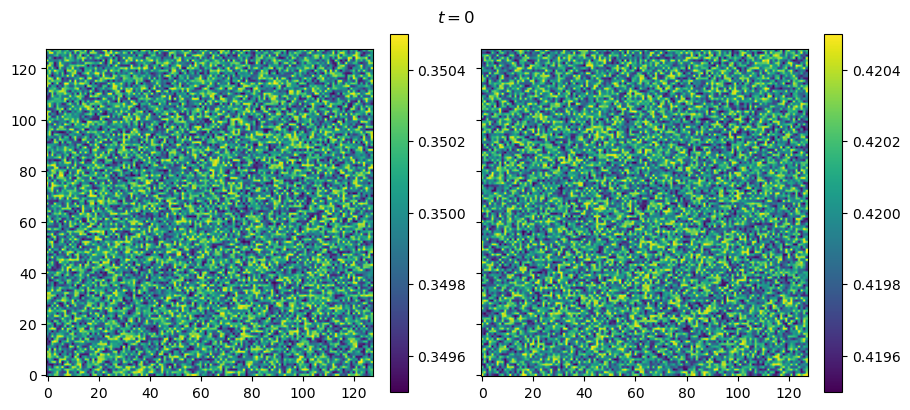

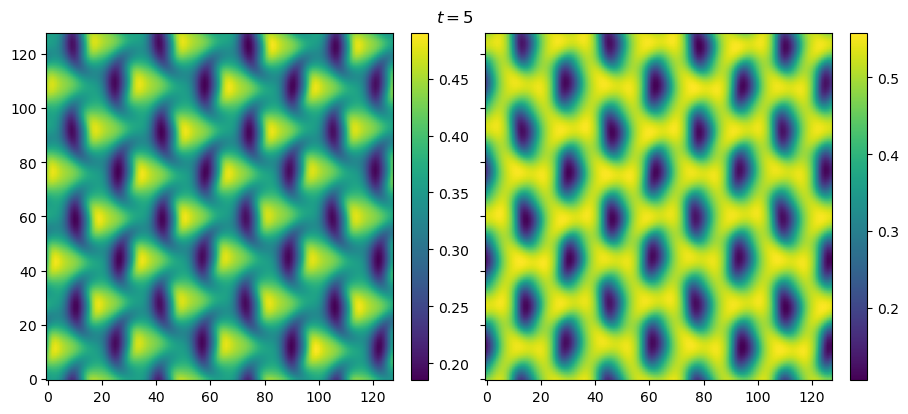

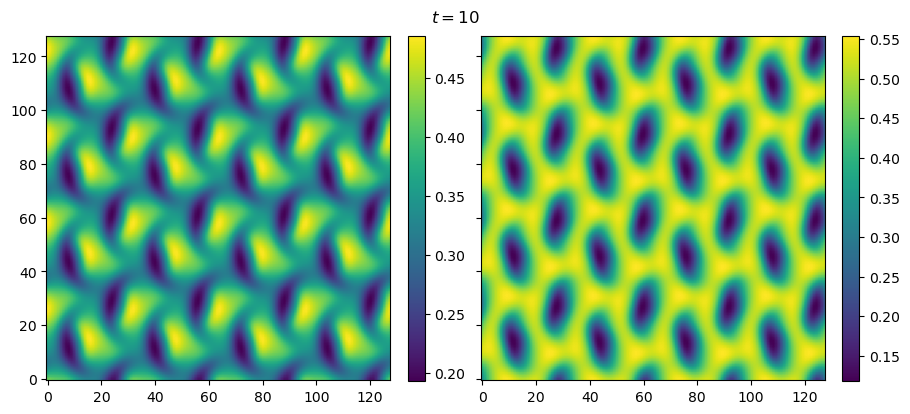

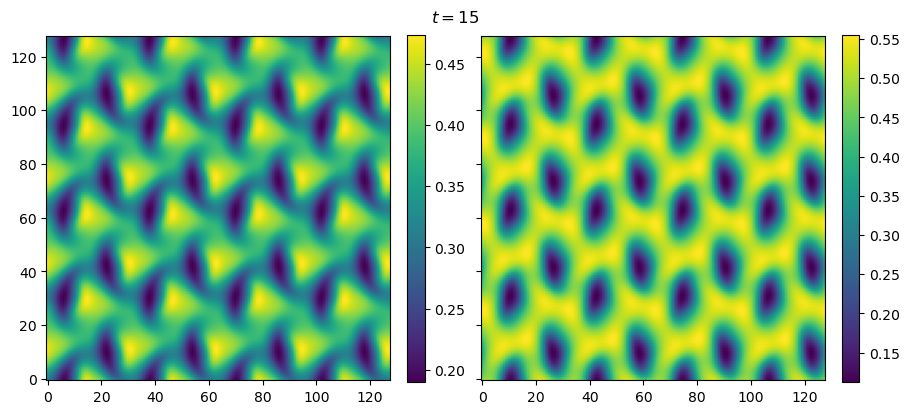

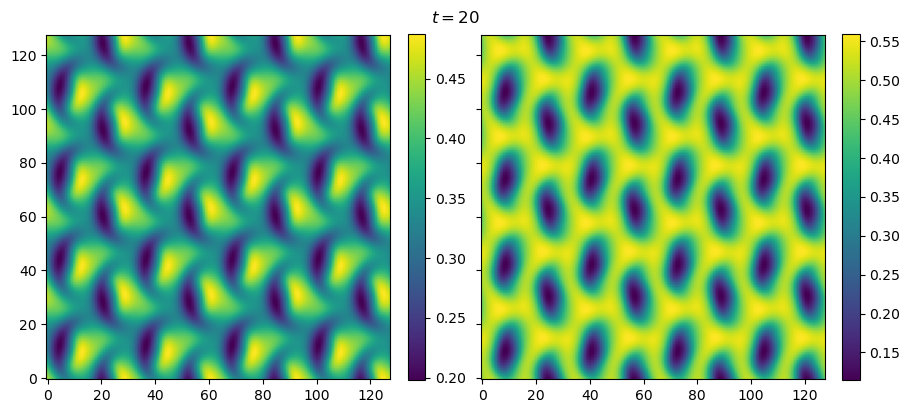

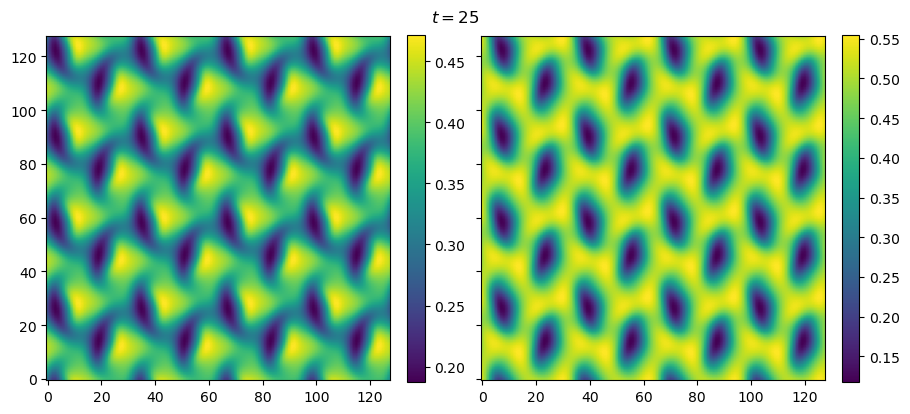

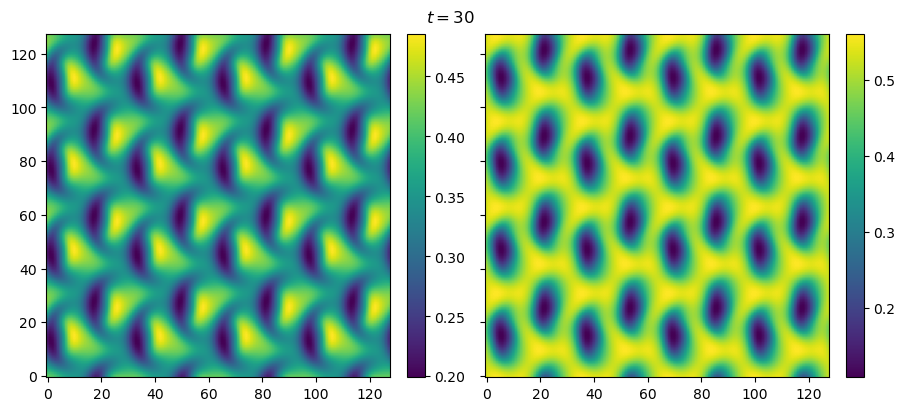

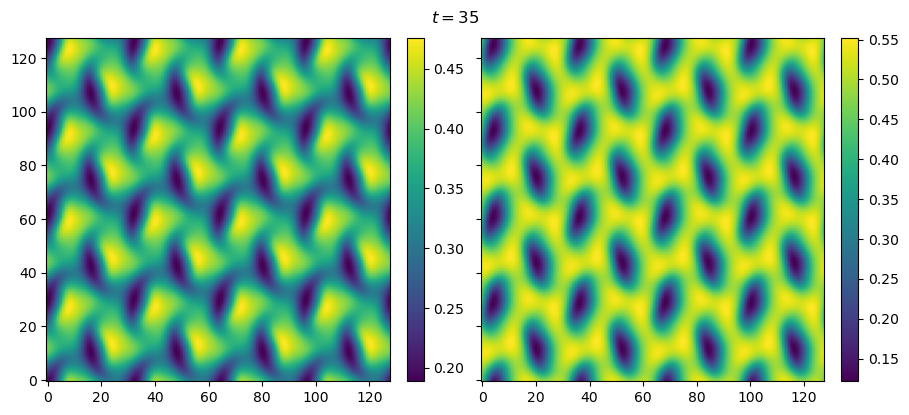

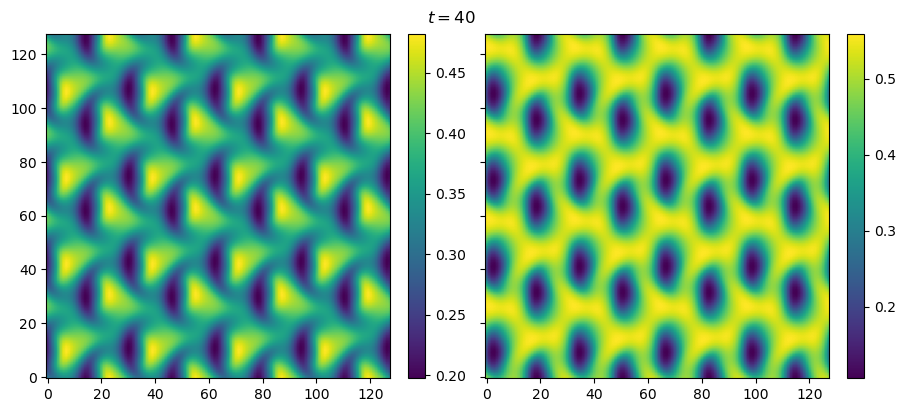

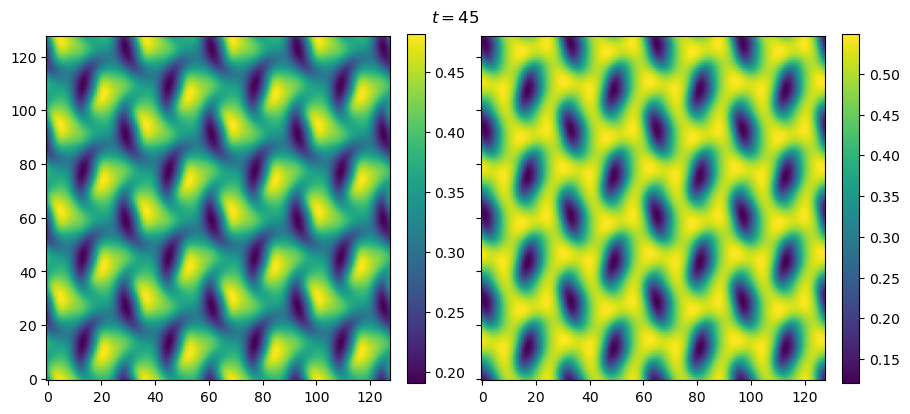

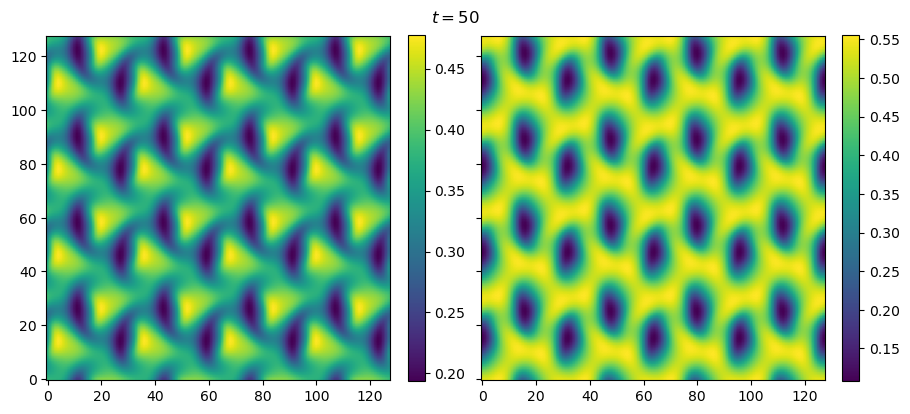

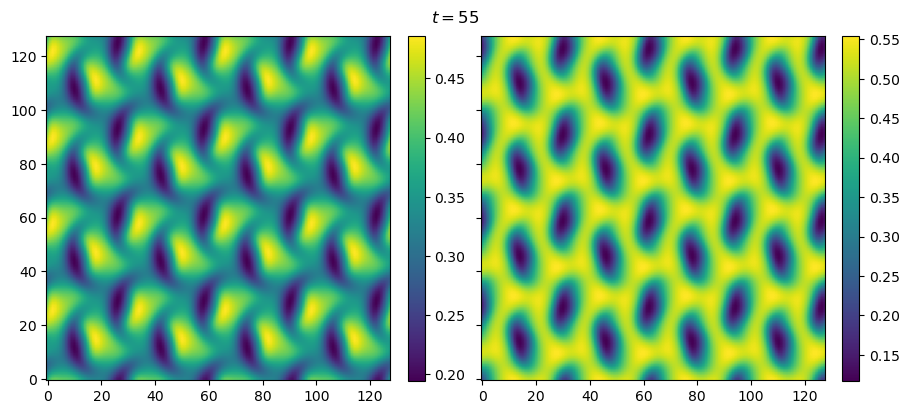

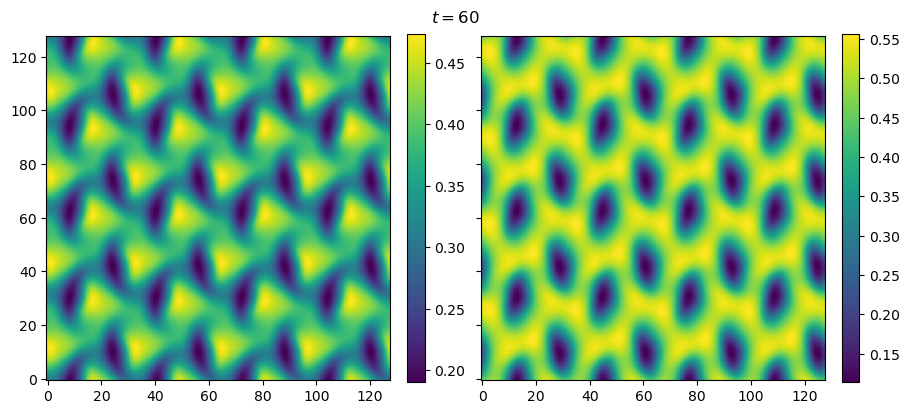

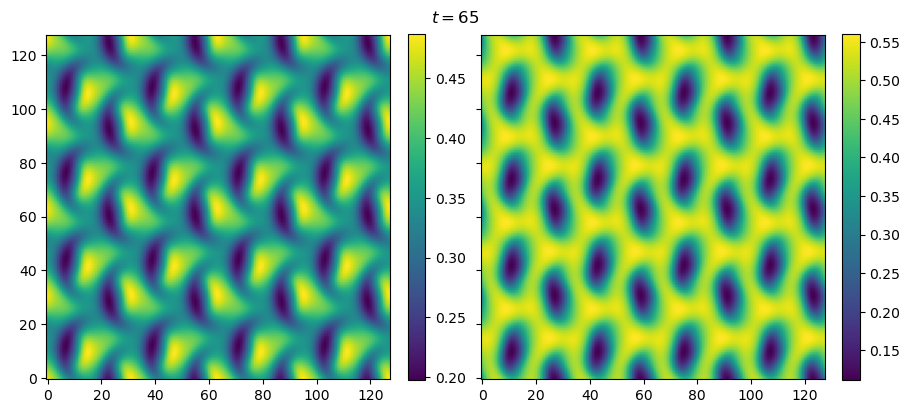

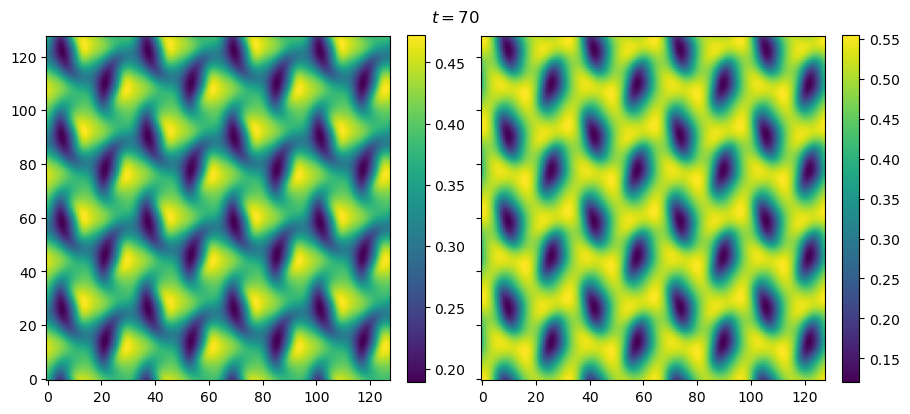

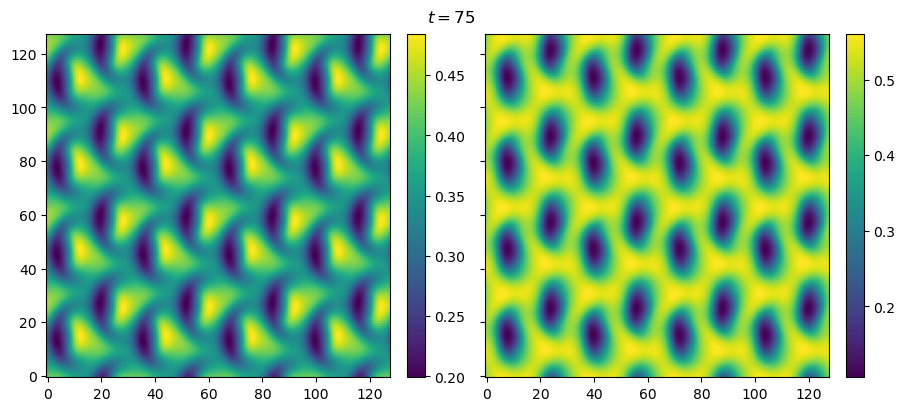

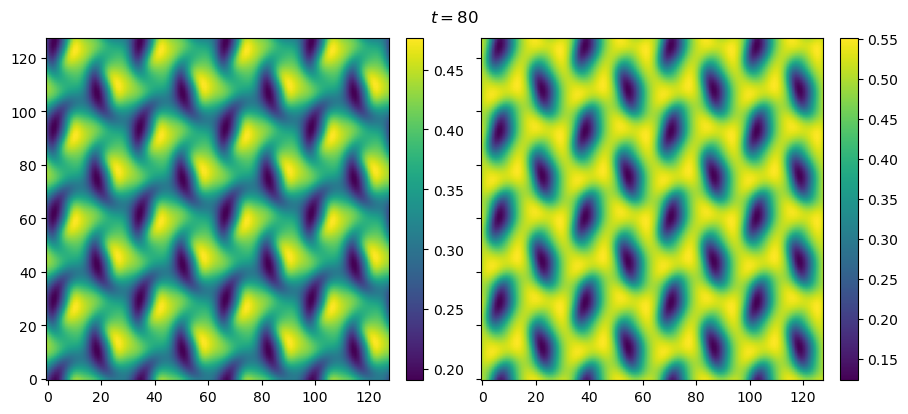

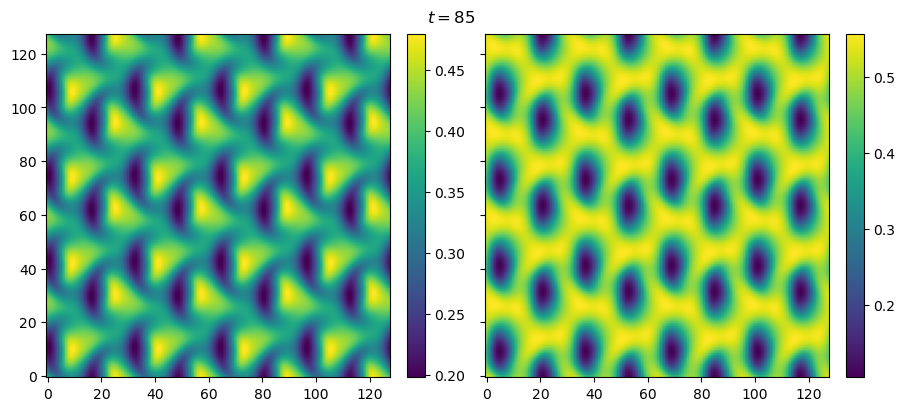

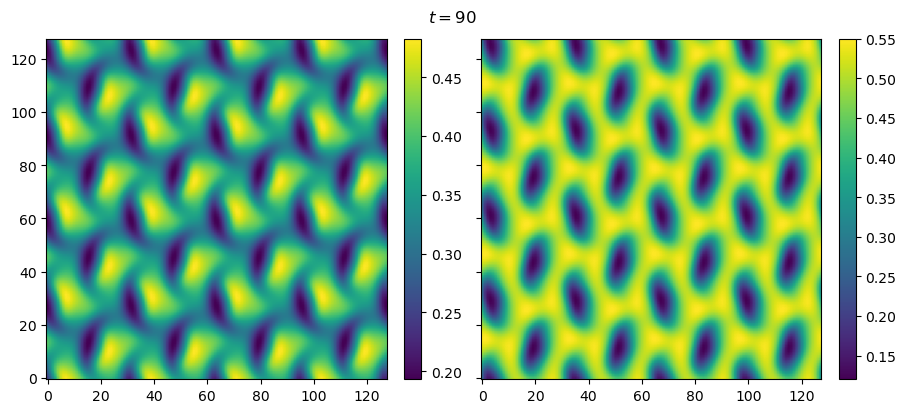

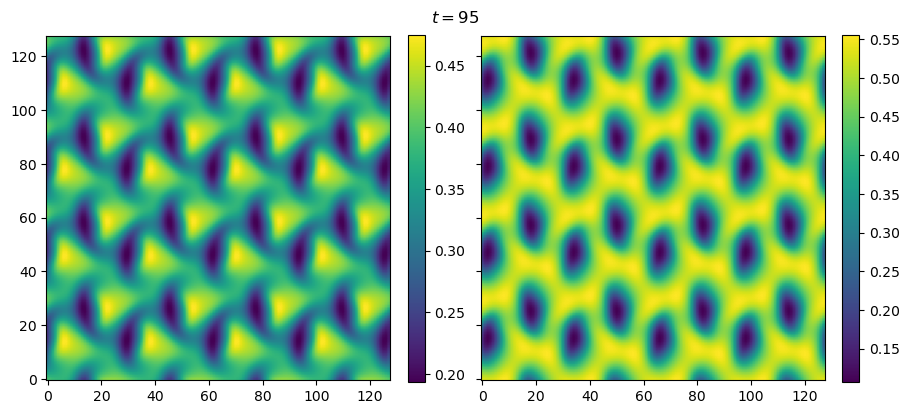

In [7]:
n_step = 200000
dn_out = 10000
# run_exEulerFS(phiA, phiB, phiA_k, phiB_k, n_step, dn_out)
run_simFS1(phiA, phiB, phiA_k, phiB_k, n_step, dn_out)
# run_simFS2(phiA, phiB, phiA_k, phiB_k, n_step, dn_out)

    